## 权重衰退

- **正则项：** 就是在损失函数中加入一个惩罚项，惩罚参数的规模，优化loss的同时也要降低参数的规模从而限制模型的容量防止过拟合，这个惩罚项就叫做正则项
$$\min \mathcal{l}(\mathbf{w}, b) \quad \text{subject to } \|\mathbf{w}\|^2 \leq \theta$$
- 更小的$\theta$就意味着更强的正则项

- 对于每个参数$\theta$ 都可以找到$\lambda$使得之前的目标函数等价于
$$\min(\quad l(\mathbf{w}, b) + \frac{\lambda}{2}\|\mathbf{w}\|^2\quad)$$
  - 超参$\lambda$控制了正则项的重要程度 
### 参数更新法则
- 计算梯度
$$\frac{\partial{}}{\partial{\mathbf{w}}}l(\mathbf{w}, b) + \frac{\lambda}{2}\|\mathbf{w}\|^2 = 
\frac{\partial{l(\mathbf{w}, b)}}{\partial{\mathbf{w}}} + \lambda \mathbf{w}$$

- 参数更新
$$\mathbf{w}_{t+1} = (1-\eta\lambda)\mathbf{w}_t - \eta\frac{\partial{l(\mathbf{w}_t,b_t)}}{\mathbf{w}_t}$$
- $\eta \lambda \text{一般} \leq 1, 在深度学习中通常叫做权重衰退$

## 代码实现
生成数据集
$$y = 0.05 + \sum_{i=1}^{d}{0.01x_i} + \epsilon, \quad \text{where} \quad \epsilon \sim \mathcal{N}(0,1)$$
- 从0实现

In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l
from torch import nn

n_train, n_test, num_inputs, batch_size = 20, 100, 100, 5
# Generate the dataset
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size)

In [4]:
# init the parameters
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

# define the penalty
def l2_penalty(w: torch.Tensor):
    return torch.sum(w.pow(2)) / 2

# define the train function
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log', 
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w,b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print("w 的 L2范数是", torch.norm(w).item())

w 的 L2范数是 8.306417465209961


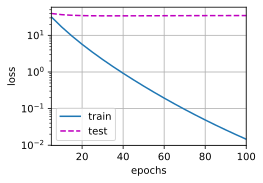

In [5]:
train(0)

w 的 L2范数是 0.2445090413093567


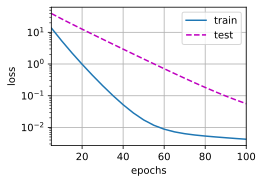

In [6]:
train(3)

- 简洁实现

In [7]:
def train_concise(wd):
    # define the model
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    # init the params
    for param in net.parameters():
        param.data.normal_()
    # define the loss function
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # define the optimizer
    trainer = torch.optim.SGD([
        {'params': net[0].weight, 'weight_decay': wd},
        {'params': net[0].bias}
    ], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', legend=['train', 'test'], 
                            xlim=[5, num_epochs], yscale='log')
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 8.95699691772461


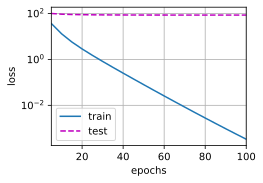

In [8]:
train_concise(0)

w的L2范数： 0.22295105457305908


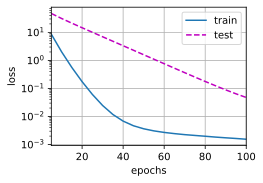

In [9]:
train_concise(3)